# Task 2: Train, validate and develop a Machine Learning pipeline using PyCaret.

### Ian Chia (230746D)

### Melbourne Housing Dataset

In [1]:
# check installed version of pycaret
import pycaret
pycaret.__version__

'3.3.2'

In [1]:
#import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from datetime import datetime
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
    median_absolute_error,
    explained_variance_score,
    max_error
)
import numpy as np
import pandas as pd


### To start off, I will be loading the dataset that I have previously saved from task 1 where I did EDA and some basic cleaning and transformation

In [2]:
#Load the dataset from task 1
df = pd.read_csv('melbourne_cleaned.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,Seller,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Region,Propertycount
0,Airport West,154 Halsey Rd,3,t,840000,PI,Nelson,2023-09-03,13.5,3042,...,2,1.0,303,225.0,2016.0,Moonee Valley,-37.7180,144.8780,Western Metropolitan,3464
1,Albert Park,105 Kerferd Rd,2,h,1275000,S,hockingstuart,2023-09-03,3.3,3206,...,1,0.0,120,82.0,1900.0,Port Phillip,-37.8459,144.9555,Southern Metropolitan,3280
2,Albert Park,85 Richardson St,2,h,1455000,S,Thomson,2023-09-03,3.3,3206,...,1,0.0,159,126.0,1970.0,Port Phillip,-37.8450,144.9538,Southern Metropolitan,3280
3,Alphington,6 Smith St,4,h,2000000,S,Brace,2023-09-03,6.4,3078,...,2,4.0,853,263.0,1930.0,Darebin,-37.7707,145.0318,Northern Metropolitan,2211
4,Alphington,5/6 Yarralea St,3,h,1110000,S,Jellis,2023-09-03,6.4,3078,...,2,2.0,208,126.0,2013.0,Yarra,-37.7854,145.0325,Northern Metropolitan,2211


### Making sure all those missing values has been removed from task 1

In [3]:
# Basic target check – make sure 'Price' exists and has data
TARGET = "Price"  # change if your target column is named differently
assert TARGET in df.columns, f"Target column '{TARGET}' not found!"

print("Rows with missing target:", df[TARGET].isna().sum())
print("Any duplicate rows:", df.duplicated().sum())
print("NA counts (top 20):")
df.isna().sum().sort_values(ascending=False).head(20)


Rows with missing target: 0
Any duplicate rows: 0
NA counts (top 20):


Suburb          0
Bathroom        0
Region          0
Longtitude      0
Lattitude       0
CouncilArea     0
YearBuilt       0
BuildingArea    0
Landsize        0
Car             0
Bedroom2        0
Address         0
Postcode        0
Distance        0
Date            0
Seller          0
Method          0
Price           0
Type            0
Rooms           0
dtype: int64

-----------------

### Converting data types 

- **Categorical columns**:  
  Columns such as **Suburb**, **Type**, **Method**, **Seller**, **CouncilArea**, and **Region** 
  were converted from  'object' to 'category'.  
  This conversion is useful because:
  - It reduces memory usage by storing repeated labels more efficiently.
  - It speeds up operations like grouping, filtering, and encoding for modeling.
  - It makes clear to both humans and machine learning algorithms that 
    these columns represent **categories/labels** rather than free text.

In [4]:
#convert data types
#Categorical columns (should be category type for efficiency):
for col in ['Suburb','Type','Method','Seller','CouncilArea','Region']:
    df[col] = df[col].astype('category')


### Ensure that the data has been succesfully converted

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         13580 non-null  category
 1   Address        13580 non-null  object  
 2   Rooms          13580 non-null  int64   
 3   Type           13580 non-null  category
 4   Price          13580 non-null  int64   
 5   Method         13580 non-null  category
 6   Seller         13580 non-null  category
 7   Date           13580 non-null  object  
 8   Distance       13580 non-null  float64 
 9   Postcode       13580 non-null  int64   
 10  Bedroom2       13580 non-null  int64   
 11  Bathroom       13580 non-null  int64   
 12  Car            13580 non-null  float64 
 13  Landsize       13580 non-null  int64   
 14  BuildingArea   13580 non-null  float64 
 15  YearBuilt      13580 non-null  float64 
 16  CouncilArea    13580 non-null  category
 17  Lattitude      13580 non-null  

--------------------------------

## Light feature cleaning before the "PyCaret" setup

To simplify the model and reduce noise/overfitting, I removed a few columns that add little generalizable signal or duplicate information:

Address – They are all unique IDs; very high cardinality → encourages memorization, not learning.

Seller – Similarly, high-cardinality categorical; agent names don’t generalize well.

Postcode – redundant with existing location fields (e.g., Suburb/Region).

Bedroom2 – highly collinear with Rooms (duplicate bedroom count); keep only Rooms. This is taken from the **correlation matrix** which was did in **task 1**

CouncilArea – overlaps with Suburb/Region; dropping reduces redundant location granularity.


In [5]:
#drop columns here 
import pandas as pd

# 2) Columns to drop (balanced plan)
drop_cols = [
    'Address',     # high cardinality
    'Seller',      # high cardinality
    'Postcode',    # redundant with Suburb/Region
    'Bedroom2',    # duplicate-ish of Rooms
    'CouncilArea',  # redundant with Region/Suburb (choose to drop)
]
drop_cols = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=drop_cols)

df.shape, df.columns.tolist()


((13580, 16),
 ['Suburb',
  'Rooms',
  'Type',
  'Price',
  'Method',
  'Date',
  'Distance',
  'Bathroom',
  'Car',
  'Landsize',
  'BuildingArea',
  'YearBuilt',
  'Lattitude',
  'Longtitude',
  'Region',
  'Propertycount'])

### Additional - I notice that in the dataset, there are longtitude and latitude values. However I chose not to remove them as: 

Latitude and Longitude are very powerful predictors of house price because:

- Precise location → housing markets are highly location-dependent. Two properties with the same number of rooms/land size can have very different prices if one is near the CBD or in a desirable suburb.

- Better than categorical suburbs alone → Suburb/Region are categorical groupings, but lat/long provide continuous spatial information, letting the model learn fine-grained differences even within the same suburb.

- Works well with tree-based models → models like Random Forest, Gradient Boosting, XGBoost, **CatBoost** can split on lat/long to form **“location clusters”** that align with real estate pricing patterns.

- Reduces information loss → if only Region/Suburb are kept, the model may lose subtle pricing variation across neighborhoods that lat/long capture.

In [7]:
df.to_csv("New_train_melbourne_clean.csv" , index=False)

-------------------------------

### - Environment is initialised with some additional preprocessing tasks such as scaling and normalisation, automatic feature engineering and binning continuous data. 

In [10]:
from pycaret.regression import setup

# (Optional) only bin columns that actually exist to avoid KeyErrors
bin_cols = [c for c in ['Rooms','Distance','Landsize','BuildingArea','YearBuilt'] if c in df.columns]

s = setup(
    data=df,
    target='Price',
    session_id=123,

    # Scaling & normalization
    normalize=True,
    normalize_method='minmax',

    # Binning of continuous features
    bin_numeric_features=bin_cols
)


,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(13580, 17)"
4,Transformed data shape,"(13580, 30)"
5,Transformed train set shape,"(9506, 30)"
6,Transformed test set shape,"(4074, 30)"
7,Numeric features,12
8,Categorical features,4
9,Preprocess,True


### What additional preprocessing steps were being done in the set-up code above

- In this step, I initialize the PyCaret regression environment with Price as the target.

- Min-Max normalization is applied to scale all numeric features between 0 and 1.

- Selected continuous variables (Rooms, Distance, Landsize, BuildingArea, YearBuilt) are binned into intervals, turning them into categorical groups.

This ensures the data is on a consistent scale and helps the model capture nonlinear patterns from continuous features.

-------------------------

### - Models are trained and evaluated according to multiple performance metrics using k-fold cross-validation.

In this step, I used compare_models() to automatically train and evaluate a wide range of regression algorithms. PyCaret runs each model using k-fold cross-validation and reports multiple performance metrics (such as RMSE, MAE, and R²). This makes it easy to identify the best-performing model for the dataset.

In [11]:
from pycaret.regression import compare_models

best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,174708.7136,79877444931.2674,281866.2353,0.7958,0.2154,0.1691,2.3020
lightgbm,Light Gradient Boosting Machine,178194.6334,81457678087.3383,284668.1411,0.7915,0.2195,0.1738,1.2210
xgboost,Extreme Gradient Boosting,182382.4453,87151646565.6537,294406.5709,0.7772,0.2265,0.1762,0.2720
rf,Random Forest Regressor,184924.5383,90193177270.1825,299660.1012,0.7692,0.2269,0.1795,2.5780
et,Extra Trees Regressor,190445.2083,95202346658.5544,307863.9840,0.7564,0.2333,0.1836,1.8020
gbr,Gradient Boosting Regressor,196152.9084,95691231371.8038,308484.0286,0.7555,0.2401,0.1937,0.4860
lar,Least Angle Regression,248398.9614,133735089495.8772,364673.8561,0.6585,0.4510,0.2734,0.0880
ridge,Ridge Regression,248195.2769,133743272782.1192,364679.7413,0.6585,0.4451,0.2731,0.0800
lasso,Lasso Regression,248395.3869,133734501420.9773,364672.9594,0.6585,0.4504,0.2734,1.5130
br,Bayesian Ridge,248267.4552,133738837915.5289,364675.7001,0.6585,0.4454,0.2732,0.0850


### Result evaluation

Boosting algorithms (CatBoost, LightGBM, XGBoost) are the best suitable for this dataset, this is because they handle categorical variables, nonlinearities, and feature interactions very well.

Among all the models **CatBoost** is the top candidate for fine-tuning and further evaluation with a **R2** of about **79.5%**.
- CatBoost Regressor performed the best overall with the lowest MAE (174,708) and lowest RMSE (281,866), while also achieving the highest R² (0.796) among all models. It also gave the lowest MAPE (0.169), showing strong predictive accuracy relative to house prices.
  
- LightGBM and XGBoost also performed decently well, as they have R2 above 0.77 and errors slightly above Catboost.
  
- Random Forest and Extra Trees did well too with R2 being above 0.76 however its RMSE will higher as compared to the boosting model

- Linear models had an R2 at about 0.65 but its erros were way higher showing thier difficulty in capturing non-linear relationships

- Simple models like Decision Tree, kNN, and AdaBoost performed worse, with lower R² values and higher error metrics.


-----------------------------

### - Analyse the performance of a trained model on the test set using the plot_model or evaluate_model function.

After figuring out the best model, I used **tune_model** to do some hyperparameter tuning. This step searches for the best set of parameters that minimize error metrics such as RMSE and MAE.

I then applied evaluate_model() to generate interactive plots (e.g., residuals, prediction errors, learning curves) that help in analyzing the model’s performance and diagnosing potential issues.

In [13]:
from pycaret.regression import *
fine_tune_model = tune_model(best) 
evaluate_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,173632.3435,97622682467.0087,312446.2873,0.7706,0.2163,0.1634
1,181735.8459,84753268545.0832,291124.1463,0.7920,0.2294,0.1807
2,181587.5276,82098377119.7825,286528.1437,0.7957,0.2369,0.1873
3,189121.3569,97480109562.2704,312218.0481,0.7526,0.2208,0.1725
4,170135.5233,64563837746.3378,254094.1513,0.7939,0.2108,0.1708
5,181641.3533,85467672617.0061,292348.5465,0.7806,0.2148,0.1720
6,179103.9570,82327955596.3752,286928.4852,0.7930,0.2133,0.1713
7,174908.7669,70031874524.7293,264635.3614,0.8094,0.2144,0.1695
8,168001.2339,68601136322.7880,261918.1863,0.8122,0.2131,0.1659


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Result evaluation 
PyCaret ran hyperparameter tuning on my best model which is **CatBoost Regressor**

- 10 different hyperparameter settings (10 candidates) across 10 folds of cross-validation.

#### After tuning, 
After tuning, the mean R² = 0.787 and RMSE ≈ 287,775.

These are very close to (and slightly worse than) the original CatBoost results (R² ~0.796, RMSE ~281,866).

So tuning didn’t improve performance — the default hyperparameters PyCaret picked initially were already strong.

**Therefore due to this, PyCaret automatically reverted back to the orignal model as **fine_tune_model**

----------------------

### Use the final model to generate predictions on unseen data with the predict_model function.

With predict_model(fine_tune_model), I evaluated the chosen model on PyCaret’s holdout test set (data not used during training or cross-validation). This produces predictions alongside actual values, and computes performance metrics on unseen data.

This step is important to check how well the model generalizes beyond the training folds.

### - Predict on the testing dataset

In [16]:
predict_model(fine_tune_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,179101.6078,104940661566.9572,323945.4608,0.7672,0.2195,0.1669


,Suburb,Rooms,Type,Method,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Region,Propertycount,YearSold,MonthSold,Price,prediction_label
5799,Endeavour Hills,4,h,SP,28.5,2,2.0,669,165.0,1980.0,-37.964661,145.270065,South-Eastern Metropolitan,8443,2024,7,625000,7.301246e+05
10596,Airport West,3,h,PI,13.5,1,1.0,585,126.0,1970.0,-37.720001,144.878006,Western Metropolitan,3464,2024,2,720000,7.549256e+05
7471,Rosanna,3,h,S,11.4,2,1.0,323,142.0,2015.0,-37.735901,145.061401,Eastern Metropolitan,3540,2023,9,1012000,8.728972e+05
2308,Hawthorn,3,h,S,4.6,1,1.0,342,130.0,1900.0,-37.813999,145.021194,Southern Metropolitan,11308,2023,11,1712000,1.609190e+06
2602,Kensington,3,t,S,3.4,2,2.0,0,120.0,1999.0,-37.794819,144.921921,Northern Metropolitan,5263,2024,7,967000,1.044739e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13413,Armadale,2,u,SP,6.3,0,0.0,0,126.0,1970.0,-37.856800,145.016098,Southern Metropolitan,4836,2023,7,546000,5.599884e+05
10948,Canterbury,3,h,PI,9.0,2,2.0,361,216.0,1995.0,-37.820599,145.078506,Southern Metropolitan,3265,2023,7,1850000,1.833714e+06
12172,Kew,4,h,S,5.6,3,2.0,627,126.0,1970.0,-37.791500,145.034805,Southern Metropolitan,10331,2023,11,2245000,2.238591e+06
2561,Fitzroy North,2,h,VB,3.6,1,1.0,184,79.0,1900.0,-37.784931,144.988785,Northern Metropolitan,6244,2024,7,1350000,1.080584e+06


### Results Evaluation 

PyCaret has automatically set aside 20% of the data as the test split during setup() 

**Metrics displayed at the top**

MAE = 179,101

MSE = 1.05e11

RMSE = 323,945

R² = 0.767

MAPE = 0.1669
**- These are the model’s performance numbers on unseen data**

When evaluated on the holdout set, the CatBoost model achieved an RMSE of ~324k and R² of 0.767. This is slightly worse than the cross-validation performance (RMSE ~288k, R² ~0.787) but still close, indicating the model generalizes well to unseen data. The small performance gap between training (CV) and holdout is expected and suggests the pipeline is not overfitting heavily.

----------------

### - Save the entire pipline

This stores the entire preprocessing and modeling pipeline (scaling, encoding, binning, feature transformations, and the trained model) into a serialized .pkl file. The saved pipeline can later be loaded back into Python or integrated into a deployment environment (e.g., Streamlit) without retraining.

In [17]:
# save pipeline
save_model(fine_tune_model, 'melbourne_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Rooms', 'Distance', 'Bathroom',
                                              'Car', 'Landsize', 'BuildingArea',
                                              'YearBuilt', 'Lattitude',
                                              'Longtitude', 'Propertycount',
                                              'YearSold', 'MonthSold'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Suburb', 'Type', 'Method',
                                              'Region'],
                                     t...
                                     transformer=TargetEncoder(cols=['Suburb'],
                                                               handle_missing='return_nan'))),
                 ('bin_numeric_features',
                  TransformerWrapper(incl

### Now since I have successfully save the pipeline, I will be loading the pipeline. This is a natural follow up.

#### This step is crucial as it ensures my pipeline can be re-used without retraining, which is crucial for deployment and reproducibility.

In [18]:
# load pipeline
loaded_best_pipeline = load_model('melbourne_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\IANCHI~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Rooms', 'Distance', 'Bathroom',
                                             'Car', 'Landsize', 'BuildingArea',
                                             'YearBuilt', 'Lattitude',
                                             'Longtitude', 'Propertycount',
                                             'YearSold', 'MonthSold'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(in...
                                    transformer=TargetEncoder(cols=['Suburb'],
                                                              handle_missing='return_nan'))),
                ('bin_numeric_features',
                 TransformerWrapper(include=['Rooms', 'Distance', 'Landsize',
                                             'BuildingArea', 'YearBuilt'],
                                    transformer=KBinsDiscretizer(encode='ordinal',
                                                                 strategy='kmeans'))),
                ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x000001CDF8E8FA60>)])

------------------------

### - Register/Import the model into mlflow

In [27]:
# Compute metrics on PyCaret's holdout and finalize the model for deployment
from pycaret.regression import predict_model, finalize_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Use your tuned model variable name here (change if different)
tuned_model = fine_tune_model

# 1) Holdout predictions (PyCaret attaches predictions to a DataFrame)
scored = predict_model(tuned_model)
pred_col = 'prediction_label' if 'prediction_label' in scored.columns else 'Label'
y_true = scored['Price'].to_numpy()
y_pred = scored[pred_col].to_numpy()

# 2) Metric VALUES (avoid naming clash with any rmse() helper function)
rmse_val = mean_squared_error(y_true, y_pred, squared=False)
r2_val   = r2_score(y_true, y_pred)
mae_val  = mean_absolute_error(y_true, y_pred)

# 3) Finalize full pipeline on ALL data for deployment
final_model = finalize_model(tuned_model)

# 4) Small input example for model signature
X_example = scored.drop(columns=['Price', pred_col], errors='ignore').head(5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,179101.6078,104940661566.9572,323945.4608,0.7672,0.2195,0.1669


**In this step, I prepared my tuned model for deployment and registration with MLflow:**

Holdout evaluation – I ran the tuned model on PyCaret’s holdout set using predict_model and extracted actual vs. predicted Price values. This allowed me to compute key metrics (RMSE, R², MAE) with scikit-learn functions.

Finalize the model – I used finalize_model to retrain the tuned model on the entire dataset (train + test) so the model benefits from all available data before deployment.

Prepare input example – I created a small sample of input features (without target/prediction columns) for MLflow’s model signature, which records the expected input schema.

This process ensures I have:

- Reliable evaluation metrics to log in MLflow.

- A finalized pipeline trained on all data.

- A sample input schema for reproducible deployment.

In [33]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature  # <-- add this

model_name = "melbourne_price_model"  # any registry name you like

with mlflow.start_run(run_name="melbourne_regression_run"):
    mlflow.log_metric("rmse", float(rmse_val))
    mlflow.log_metric("r2",   float(r2_val))
    mlflow.log_metric("mae",  float(mae_val))

    signature = infer_signature(X_example, final_model.predict(X_example))
    
    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="model",
        signature=signature,
        input_example=X_example,
        registered_model_name=model_name,
    )


C:\Users\ian Chia\.conda\envs\mlops\lib\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2025/08/28 16:42:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Registered model 'melbourne_price_model' already exists. Creating a new version of this model...
Created version '4' of model 'melbourne_price_model'.


### Logging and Registering the Model with MLflow  

In this step, I logged the finalized pipeline and registered it in the **MLflow Model Registry**:  

1. **Start an MLflow run** – begins a new experiment run named *melbourne_regression_run*.  
2. **Log metrics** – recorded key performance metrics (**RMSE, R², MAE**) for tracking and comparison across runs.  
3. **Create model signature** – used "infer_signature" to capture the expected input and output schema, ensuring the model can be reused consistently.  
4. **Log and register the model** – stored the entire preprocessing + model pipeline as an artifact and registered it under the name **melbourne_price_model**.  

This creates a **versioned model** in MLflow, which can later be promoted to stages (e.g., *Staging* or *Production*) and loaded back for inference using **mlflow.pyfunc.load_model**.  


------------------------

## The screenshot below from the MLflow UI confirms that the model has been successfully logged and registered:  


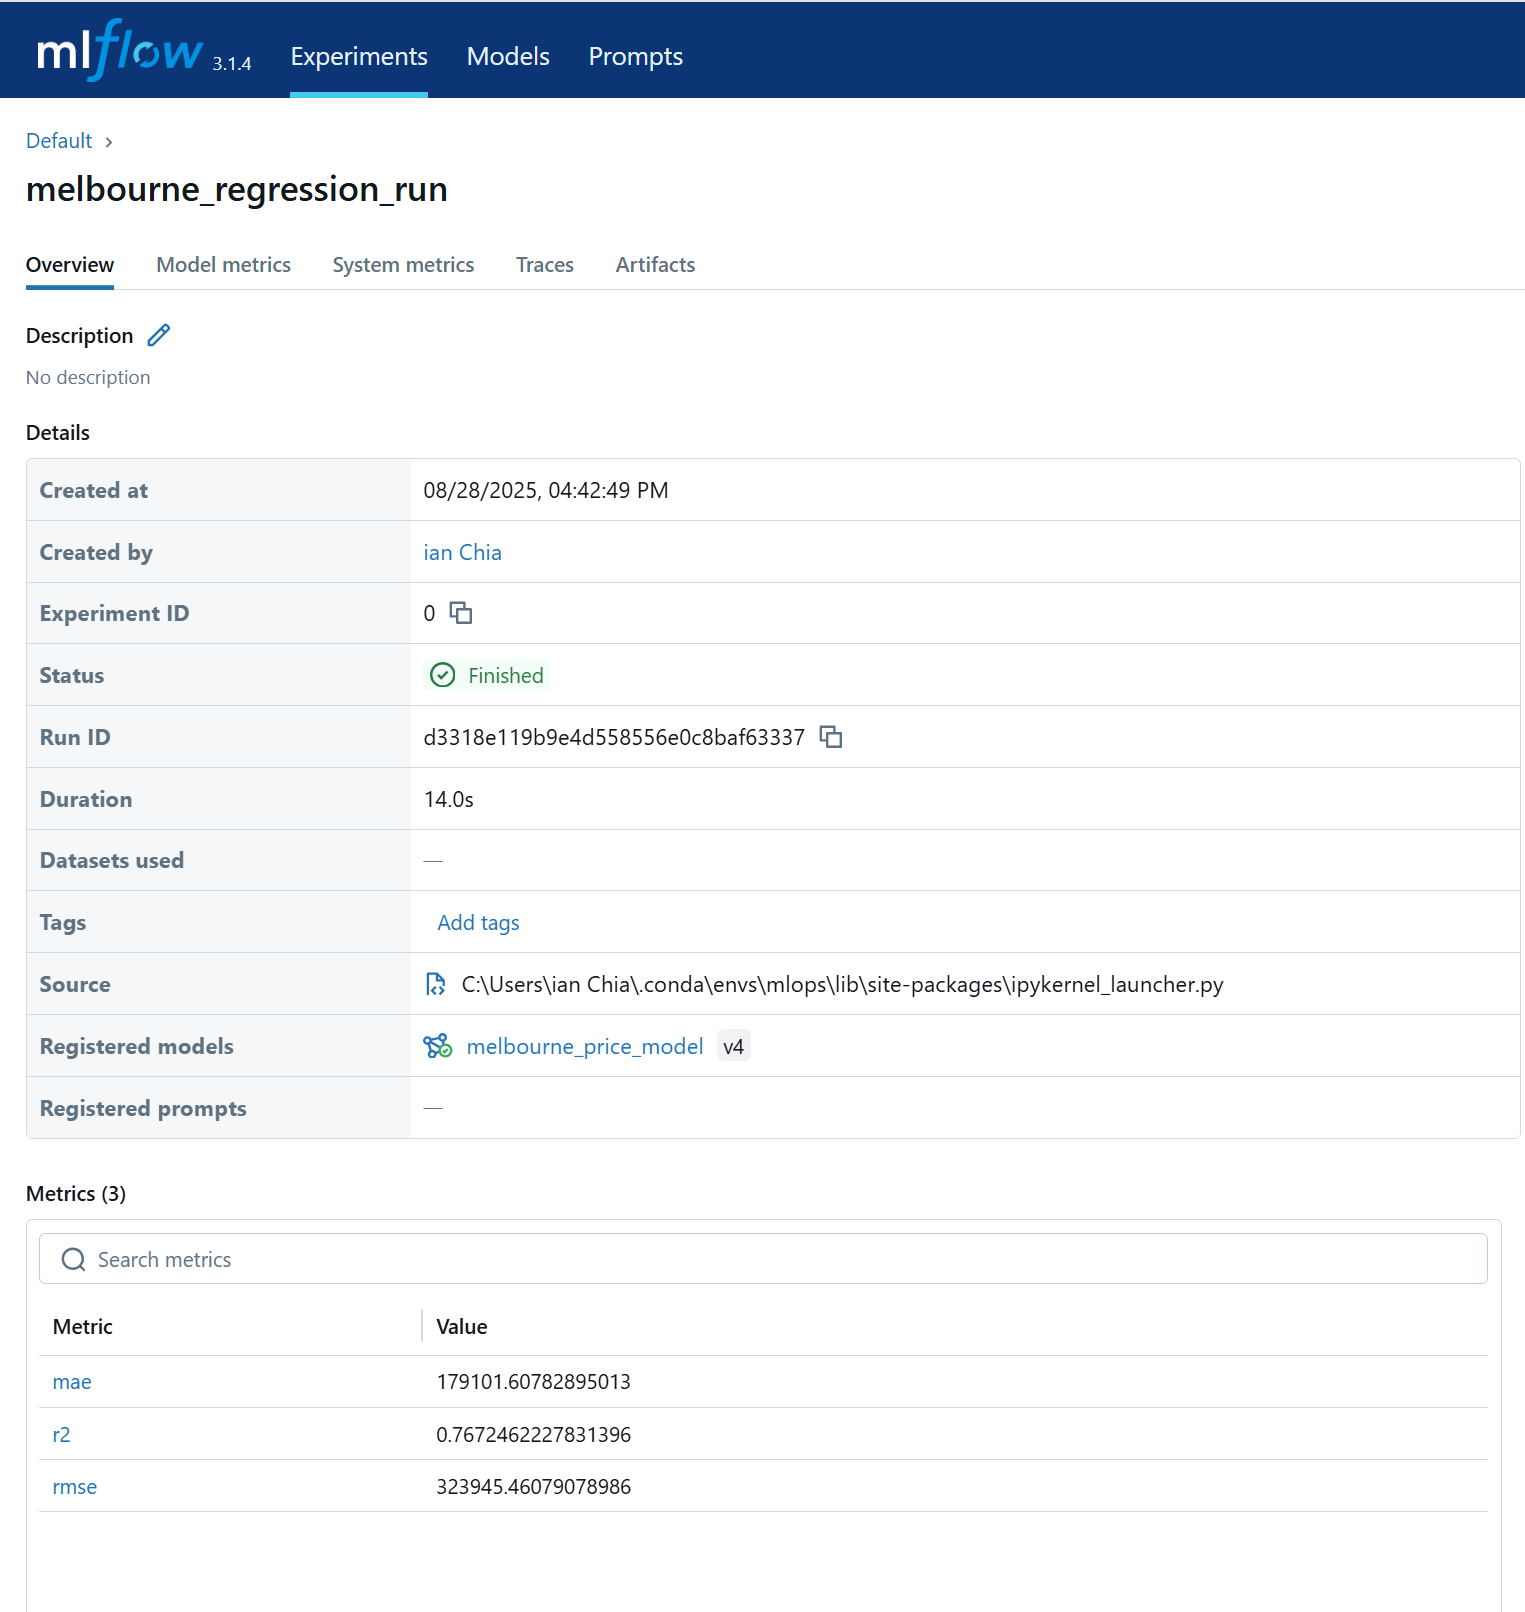